### Environment Setup
This section installs all the necessary dependencies required for the notebook. These libraries include tools for natural language processing, dataset management, and statistical analysis. If you already have a compatible environment, you can skip this step.

In [1]:
# Install dependencies (same as the env file, so you may wish to skip this if running locally / with persistent conda environment)
%pip install transformers
%pip install accelerate
%pip install bitsandbytes
%pip install pyDOE3
%pip install datasets
%pip install torch
%pip install jinja2
%pip install torchmetrics
%pip install tqdm
%pip install jupyter
%pip install pretty-jupyter
%pip install researchpy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Library Imports
Here, we import the essential Python libraries and modules that will be used throughout the notebook. These include:
- `transformers` and `datasets` for natural language processing tasks.
- `pyDOE3` for design of experiments.
- `torchmetrics` for evaluation metrics.
- `jinja2` for templating.
- `statsmodels` for statistical modeling.

In [ ]:
import pandas as pd
import csv
import tqdm
import time
import os
import jinja2
import textwrap
import datasets

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from pyDOE3 import *
from torchmetrics.text.rouge import ROUGEScore

import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt

import re  # Import regular expression module


### ROUGE Scores and Their Relevance

#### **ROUGE-1**
- **Definition**: Measures the overlap of unigrams (single words) between the candidate (rewritten) text and the reference (original) text.
- **Relevance**: 
  - High **recall** ensures that all key words from the original text are retained in the rewritten version.
  - High **precision** indicates that the rewritten text avoids including unnecessary words not present in the original.
  - **F-Measure** balances precision and recall to provide an overall alignment score.

---

#### **ROUGE-2**
- **Definition**: Measures the overlap of bigrams (two consecutive words) between the candidate and reference text.
- **Relevance**:
  - High **recall** ensures the rewritten text preserves phrasing and contextual meaning from the original.
  - High **precision** confirms that the word pairings are concise and relevant to the original.
  - **F-Measure** assesses the overall similarity in phrasing and flow between the texts.

---

#### **ROUGE-L**
- **Definition**: Evaluates the longest common subsequence (LCS) between the candidate and reference text.
- **Relevance**:
  - High **recall** indicates the rewritten text maintains the sequence and structure of the original.
  - High **precision** ensures that the sequence includes no extraneous content.
  - **F-Measure** provides a balanced metric for assessing structural and sequential fidelity.

---

#### **ROUGE-Lsum**
- **Definition**: Extends ROUGE-L to multi-sentence or paragraph-level comparisons by analyzing the longest common subsequence across text segments.
- **Relevance**:
  - Ensures that the overall structure, coherence, and flow of the rewritten text are consistent with the original at a broader level.
  - Useful for tasks involving longer passages or summaries.

---

These scores collectively evaluate how well the rewritten text adheres to the original, balancing precision (conciseness) and recall (completeness) to ensure the meaning is preserved without unnecessary additions.

/var/folders/hm/5m8v39gs5yj35nkyd_qbnpzm0000gn/T/ipykernel_35456/446722989.py:6: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./output.csv", delimiter='§')


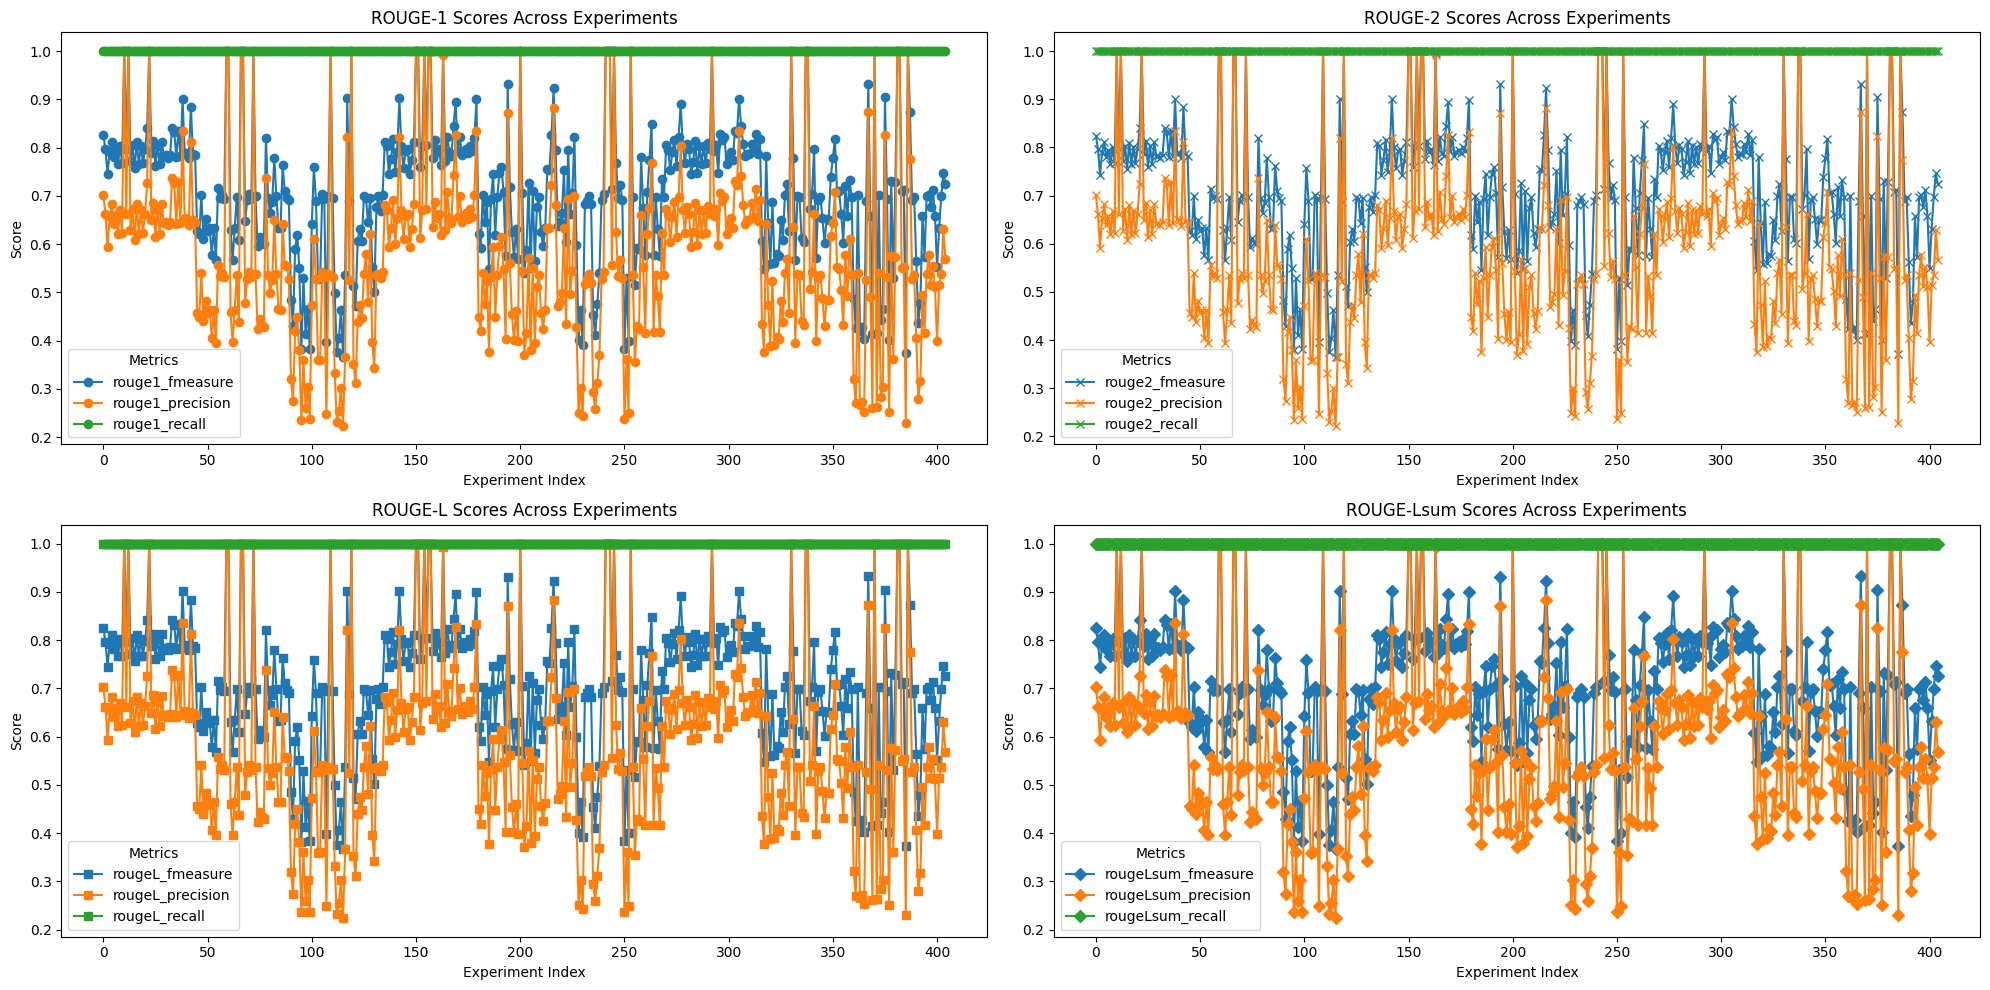

In [ ]:
# Read the CSV file containing the outputs
df = pd.read_csv("./output.csv", delimiter='§')

# Function to safely extract numeric value from a tensor string like 'tensor(0.8250)'
def extract_tensor_value(value):
    """ Extracts the float value from a tensor string like 'tensor(0.8250)' """
    if isinstance(value, str):
        # Replace 'tensor(' and ')' to extract the numeric value
        tensor_match = re.match(r"tensor\(([^)]+)\)", value)
        if tensor_match:
            return float(tensor_match.group(1))
    return value  # Return the value if it's already numeric

# Function to parse the 'score' column and convert it to a dictionary with float values
def parse_score_column(score_str):
    """ Convert the score string to a dictionary with tensor values extracted """
    # First replace tensor-like patterns with numeric values
    score_str = re.sub(r"tensor\(([^)]+)\)", r"\1", score_str)  # Replace 'tensor(x)' with 'x'
    
    # Safely evaluate the dictionary string
    score_dict = eval(score_str)  # This converts the cleaned-up string to a dictionary

    # Convert all values in the dictionary to float if they are tensor-like strings
    for key, value in score_dict.items():
        score_dict[key] = extract_tensor_value(value)
    
    return score_dict

# Apply the function to the 'score' column to convert to dictionaries with float values
df['score'] = df['score'].apply(parse_score_column)

# Now, extract the individual ROUGE metrics and convert them into separate columns
df['rouge1_fmeasure'] = df['score'].apply(lambda x: x['rouge1_fmeasure'])
df['rouge1_precision'] = df['score'].apply(lambda x: x['rouge1_precision'])
df['rouge1_recall'] = df['score'].apply(lambda x: x['rouge1_recall'])
df['rouge2_fmeasure'] = df['score'].apply(lambda x: x['rouge2_fmeasure'])
df['rouge2_precision'] = df['score'].apply(lambda x: x['rouge2_precision'])
df['rouge2_recall'] = df['score'].apply(lambda x: x['rouge2_recall'])
df['rougeL_fmeasure'] = df['score'].apply(lambda x: x['rougeL_fmeasure'])
df['rougeL_precision'] = df['score'].apply(lambda x: x['rougeL_precision'])
df['rougeL_recall'] = df['score'].apply(lambda x: x['rougeL_recall'])
df['rougeLsum_fmeasure'] = df['score'].apply(lambda x: x['rougeLsum_fmeasure'])
df['rougeLsum_precision'] = df['score'].apply(lambda x: x['rougeLsum_precision'])
df['rougeLsum_recall'] = df['score'].apply(lambda x: x['rougeLsum_recall'])

# Plotting with pandas' built-in plotting capabilities
plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
df[['rouge1_fmeasure', 'rouge1_precision', 'rouge1_recall']].plot(ax=plt.gca(), marker='o')
plt.title("ROUGE-1 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
df[['rouge2_fmeasure', 'rouge2_precision', 'rouge2_recall']].plot(ax=plt.gca(), marker='x')
plt.title("ROUGE-2 Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
df[['rougeL_fmeasure', 'rougeL_precision', 'rougeL_recall']].plot(ax=plt.gca(), marker='s')
plt.title("ROUGE-L Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
df[['rougeLsum_fmeasure', 'rougeLsum_precision', 'rougeLsum_recall']].plot(ax=plt.gca(), marker='D')
plt.title("ROUGE-Lsum Scores Across Experiments")
plt.xlabel("Experiment Index")
plt.ylabel("Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()
plt.show()

In [13]:
# Assuming the CSV file has been read into df
df = pd.read_csv("./output.csv", delimiter='§', engine='python')

# Concatenate the relevant columns to form a unique configuration string
def create_config_string(row):
    return f"Model: {row['model']}, Batch Size: {row['batch_size']}, Max Tokens: {row['max_new_tokens']}, Quantization Bits: {row['quantization']}"

# Apply the function to create a new 'config' column
df['config'] = df.apply(create_config_string, axis=1)

# Count the number of occurrences of each unique configuration
config_counts = df['config'].value_counts()

# Print the result
print(config_counts)

config
Model: meta-llama/Llama-3.2-1B, Batch Size: 1, Max Tokens: 100, Quantization Bits: 4.0    10
Model: meta-llama/Llama-3.2-3B, Batch Size: 1, Max Tokens: 100, Quantization Bits: 8.0    10
Model: meta-llama/Llama-3.2-3B, Batch Size: 1, Max Tokens: 500, Quantization Bits: 4.0    10
Model: meta-llama/Llama-3.2-3B, Batch Size: 1, Max Tokens: 100, Quantization Bits: 4.0    10
Model: meta-llama/Llama-3.1-8B, Batch Size: 1, Max Tokens: 100, Quantization Bits: nan    10
                                                                                          ..
Model: meta-llama/Llama-3.2-3B, Batch Size: 8, Max Tokens: 100, Quantization Bits: 8.0     2
Model: meta-llama/Llama-3.1-8B, Batch Size: 8, Max Tokens: 100, Quantization Bits: 8.0     2
Model: meta-llama/Llama-3.1-8B, Batch Size: 8, Max Tokens: 250, Quantization Bits: 8.0     2
Model: meta-llama/Llama-3.2-3B, Batch Size: 8, Max Tokens: 250, Quantization Bits: 8.0     2
Model: meta-llama/Llama-3.1-8B, Batch Size: 8, Max Tokens: 500,

Total number of unique configurations: 81


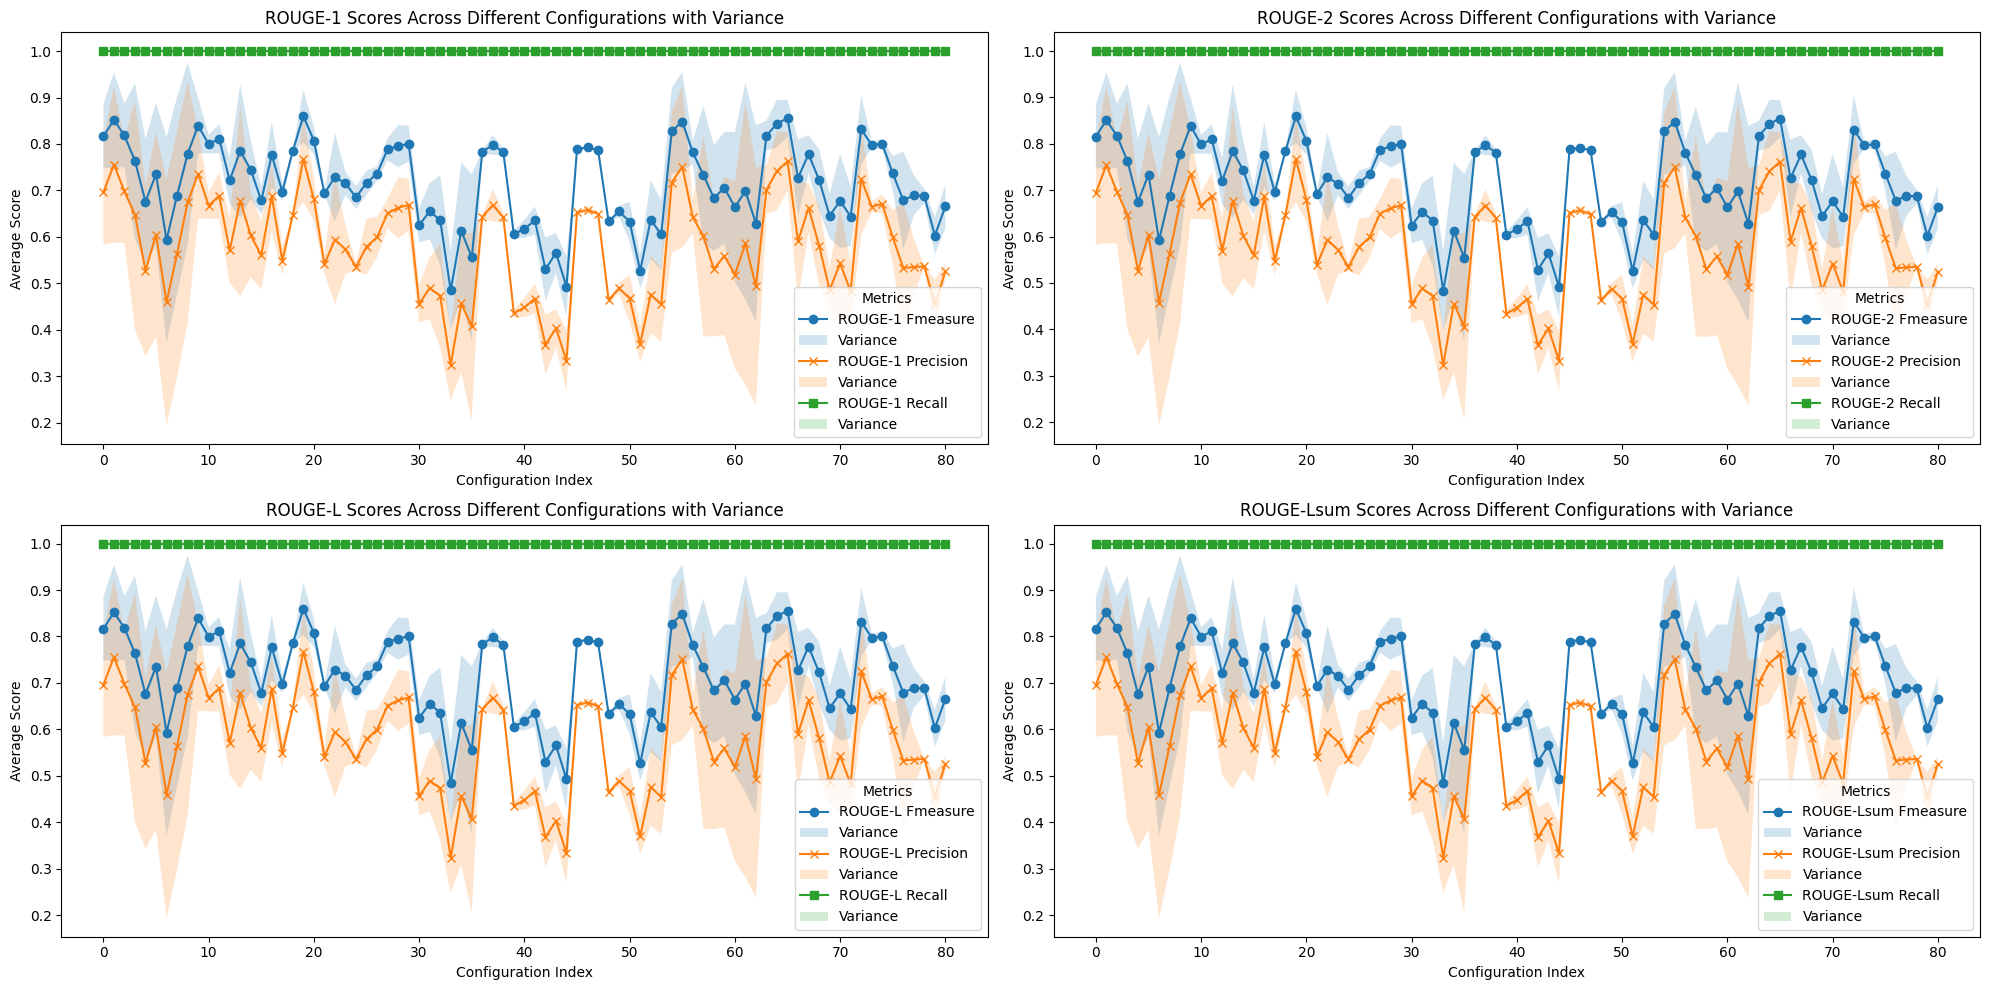

In [18]:
# Read the CSV file containing the outputs
df = pd.read_csv("./output.csv", delimiter='§', engine='python')

# Function to safely extract numeric value from a tensor string like 'tensor(0.8250)'
def extract_tensor_value(value):
    """ Extracts the float value from a tensor string like 'tensor(0.8250)' """
    if isinstance(value, str):
        # Replace 'tensor(' and ')' to extract the numeric value
        tensor_match = re.match(r"tensor\(([^)]+)\)", value)
        if tensor_match:
            return float(tensor_match.group(1))
    return value  # Return the value if it's already numeric

# Function to parse the 'score' column and convert it to a dictionary with float values
def parse_score_column(score_str):
    """ Convert the score string to a dictionary with tensor values extracted """
    # First replace tensor-like patterns with numeric values
    score_str = re.sub(r"tensor\(([^)]+)\)", r"\1", score_str)  # Replace 'tensor(x)' with 'x'
    
    # Safely evaluate the dictionary string
    score_dict = eval(score_str)  # This converts the cleaned-up string to a dictionary

    # Convert all values in the dictionary to float if they are tensor-like strings
    for key, value in score_dict.items():
        score_dict[key] = extract_tensor_value(value)
    
    return score_dict

# Apply the function to the 'score' column to convert to dictionaries with float values
df['score'] = df['score'].apply(parse_score_column)

# Now, extract the individual ROUGE metrics and convert them into separate columns
df['rouge1_fmeasure'] = df['score'].apply(lambda x: x['rouge1_fmeasure'])
df['rouge1_precision'] = df['score'].apply(lambda x: x['rouge1_precision'])
df['rouge1_recall'] = df['score'].apply(lambda x: x['rouge1_recall'])
df['rouge2_fmeasure'] = df['score'].apply(lambda x: x['rouge2_fmeasure'])
df['rouge2_precision'] = df['score'].apply(lambda x: x['rouge2_precision'])
df['rouge2_recall'] = df['score'].apply(lambda x: x['rouge2_recall'])
df['rougeL_fmeasure'] = df['score'].apply(lambda x: x['rougeL_fmeasure'])
df['rougeL_precision'] = df['score'].apply(lambda x: x['rougeL_precision'])
df['rougeL_recall'] = df['score'].apply(lambda x: x['rougeL_recall'])
df['rougeLsum_fmeasure'] = df['score'].apply(lambda x: x['rougeLsum_fmeasure'])
df['rougeLsum_precision'] = df['score'].apply(lambda x: x['rougeLsum_precision'])
df['rougeLsum_recall'] = df['score'].apply(lambda x: x['rougeLsum_recall'])
# Check if the configuration columns are being captured properly
df['configuration'] = df[['model', 'batch_size', 'max_new_tokens', 'quantization']].astype(str).agg('§'.join, axis=1)

# Group by the complete configuration and calculate the mean and variance
grouped_df = df.groupby('configuration').agg(
    rouge1_fmeasure_mean=('rouge1_fmeasure', 'mean'),
    rouge1_fmeasure_var=('rouge1_fmeasure', 'var'),
    rouge1_precision_mean=('rouge1_precision', 'mean'),
    rouge1_precision_var=('rouge1_precision', 'var'),
    rouge1_recall_mean=('rouge1_recall', 'mean'),
    rouge1_recall_var=('rouge1_recall', 'var'),
    rouge2_fmeasure_mean=('rouge2_fmeasure', 'mean'),
    rouge2_fmeasure_var=('rouge2_fmeasure', 'var'),
    rouge2_precision_mean=('rouge2_precision', 'mean'),
    rouge2_precision_var=('rouge2_precision', 'var'),
    rouge2_recall_mean=('rouge2_recall', 'mean'),
    rouge2_recall_var=('rouge2_recall', 'var'),
    rougeL_fmeasure_mean=('rougeL_fmeasure', 'mean'),
    rougeL_fmeasure_var=('rougeL_fmeasure', 'var'),
    rougeL_precision_mean=('rougeL_precision', 'mean'),
    rougeL_precision_var=('rougeL_precision', 'var'),
    rougeL_recall_mean=('rougeL_recall', 'mean'),
    rougeL_recall_var=('rougeL_recall', 'var'),
    rougeLsum_fmeasure_mean=('rougeLsum_fmeasure', 'mean'),
    rougeLsum_fmeasure_var=('rougeLsum_fmeasure', 'var'),
    rougeLsum_precision_mean=('rougeLsum_precision', 'mean'),
    rougeLsum_precision_var=('rougeLsum_precision', 'var'),
    rougeLsum_recall_mean=('rougeLsum_recall', 'mean'),
    rougeLsum_recall_var=('rougeLsum_recall', 'var'),
).reset_index()

# Make sure the grouping contains 81 configurations by checking the number of unique configurations
print(f"Total number of unique configurations: {grouped_df.shape[0]}")  # This should be 81

plt.figure(figsize=(20, 10))

# ROUGE-1
plt.subplot(2, 2, 1)
plt.plot(grouped_df.index, grouped_df['rouge1_fmeasure_mean'], marker='o', label='ROUGE-1 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_fmeasure_mean'] - grouped_df['rouge1_fmeasure_var']**0.5, 
                 grouped_df['rouge1_fmeasure_mean'] + grouped_df['rouge1_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_precision_mean'], marker='x', label='ROUGE-1 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_precision_mean'] - grouped_df['rouge1_precision_var']**0.5, 
                 grouped_df['rouge1_precision_mean'] + grouped_df['rouge1_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge1_recall_mean'], marker='s', label='ROUGE-1 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge1_recall_mean'] - grouped_df['rouge1_recall_var']**0.5, 
                 grouped_df['rouge1_recall_mean'] + grouped_df['rouge1_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-1 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-2
plt.subplot(2, 2, 2)
plt.plot(grouped_df.index, grouped_df['rouge2_fmeasure_mean'], marker='o', label='ROUGE-2 Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_fmeasure_mean'] - grouped_df['rouge2_fmeasure_var']**0.5, 
                 grouped_df['rouge2_fmeasure_mean'] + grouped_df['rouge2_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_precision_mean'], marker='x', label='ROUGE-2 Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_precision_mean'] - grouped_df['rouge2_precision_var']**0.5, 
                 grouped_df['rouge2_precision_mean'] + grouped_df['rouge2_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rouge2_recall_mean'], marker='s', label='ROUGE-2 Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rouge2_recall_mean'] - grouped_df['rouge2_recall_var']**0.5, 
                 grouped_df['rouge2_recall_mean'] + grouped_df['rouge2_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-2 Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-L
plt.subplot(2, 2, 3)
plt.plot(grouped_df.index, grouped_df['rougeL_fmeasure_mean'], marker='o', label='ROUGE-L Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_fmeasure_mean'] - grouped_df['rougeL_fmeasure_var']**0.5, 
                 grouped_df['rougeL_fmeasure_mean'] + grouped_df['rougeL_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_precision_mean'], marker='x', label='ROUGE-L Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_precision_mean'] - grouped_df['rougeL_precision_var']**0.5, 
                 grouped_df['rougeL_precision_mean'] + grouped_df['rougeL_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeL_recall_mean'], marker='s', label='ROUGE-L Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeL_recall_mean'] - grouped_df['rougeL_recall_var']**0.5,
                    grouped_df['rougeL_recall_mean'] + grouped_df['rougeL_recall_var']**0.5,
                    alpha=0.2, label='Variance')
plt.title("ROUGE-L Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# ROUGE-Lsum
plt.subplot(2, 2, 4)
plt.plot(grouped_df.index, grouped_df['rougeLsum_fmeasure_mean'], marker='o', label='ROUGE-Lsum Fmeasure')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_fmeasure_mean'] - grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 grouped_df['rougeLsum_fmeasure_mean'] + grouped_df['rougeLsum_fmeasure_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_precision_mean'], marker='x', label='ROUGE-Lsum Precision')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_precision_mean'] - grouped_df['rougeLsum_precision_var']**0.5, 
                 grouped_df['rougeLsum_precision_mean'] + grouped_df['rougeLsum_precision_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.plot(grouped_df.index, grouped_df['rougeLsum_recall_mean'], marker='s', label='ROUGE-Lsum Recall')
plt.fill_between(grouped_df.index, 
                 grouped_df['rougeLsum_recall_mean'] - grouped_df['rougeLsum_recall_var']**0.5, 
                 grouped_df['rougeLsum_recall_mean'] + grouped_df['rougeLsum_recall_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("ROUGE-Lsum Scores Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Score")
plt.legend(title='Metrics')

# Display the plots
plt.tight_layout()

Total number of unique configurations: 81


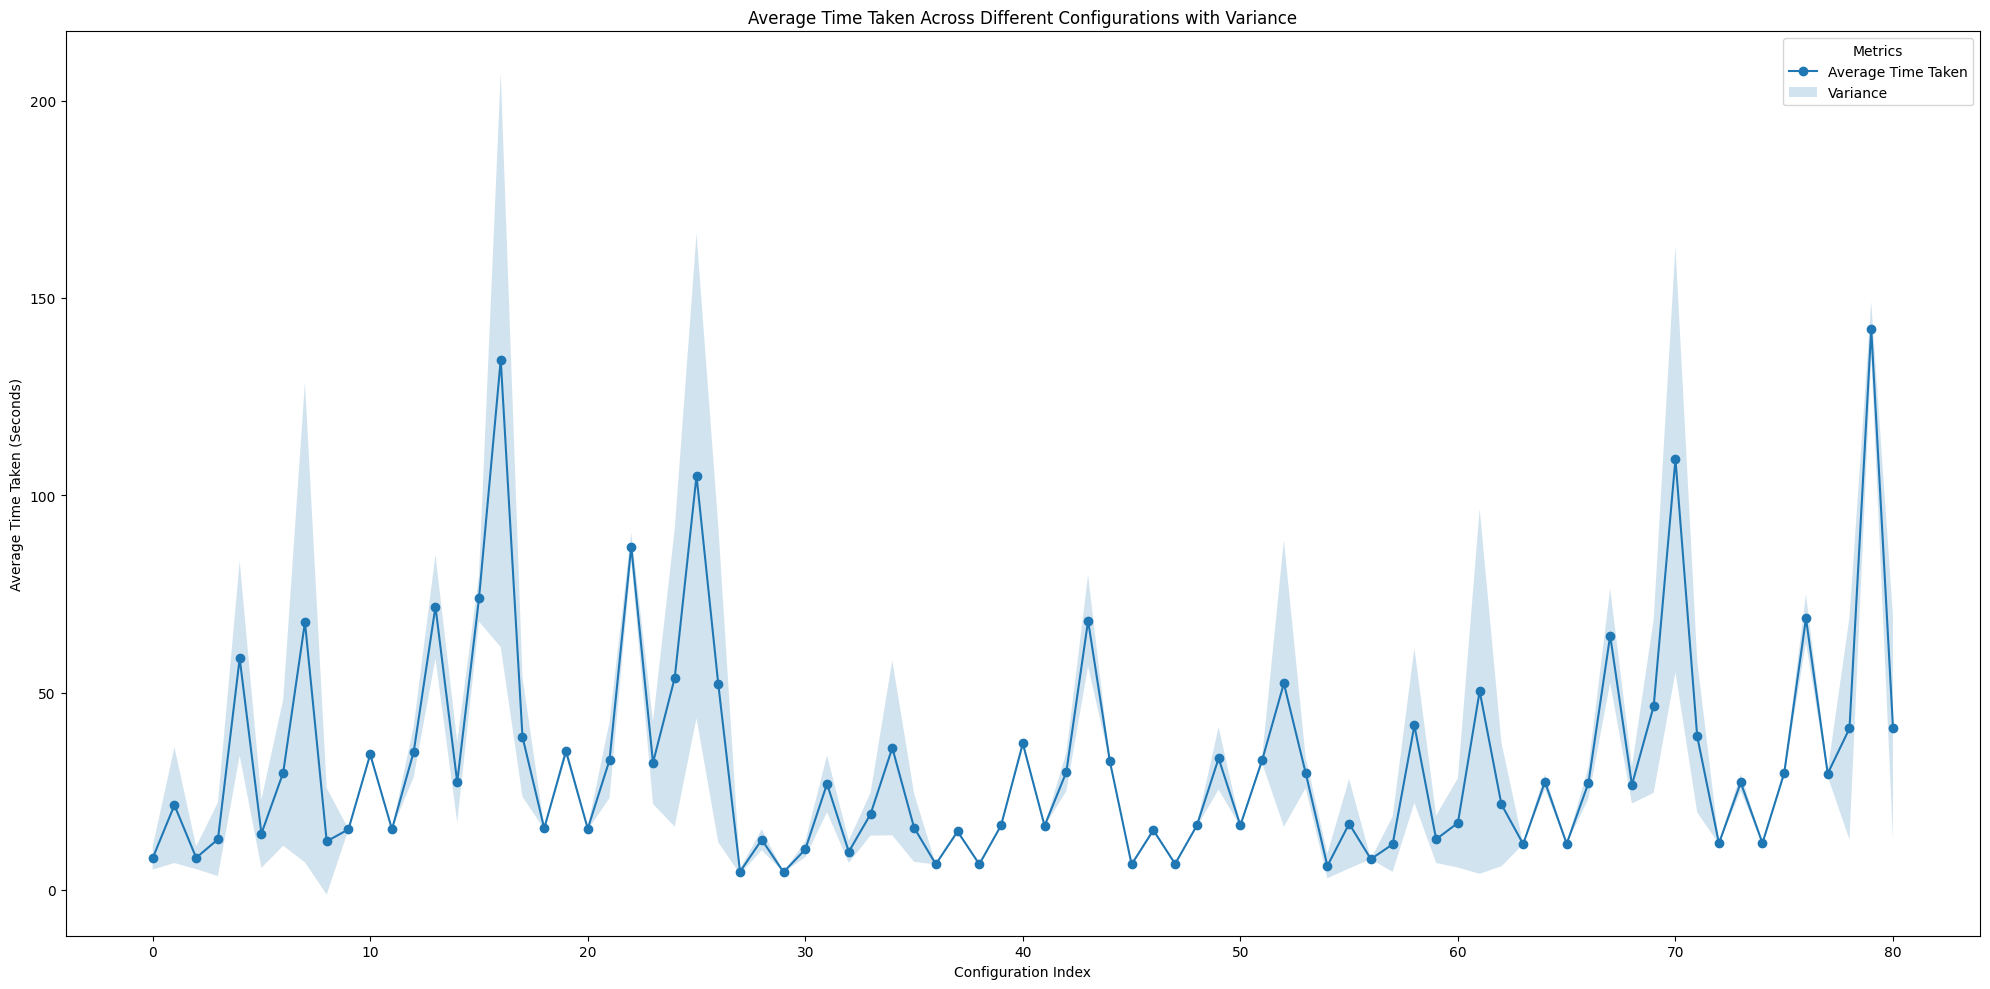

In [19]:
# Group by configuration and calculate the mean and variance for 'time_taken'
grouped_time_df = df.groupby('configuration').agg(
    time_taken_mean=('time_taken', 'mean'),
    time_taken_var=('time_taken', 'var')
).reset_index()

# Make sure the grouping contains the expected number of configurations
print(f"Total number of unique configurations: {grouped_time_df.shape[0]}")  # This should match the expected count (e.g., 81)

# Plotting the 'time_taken' values along with the variance
plt.figure(figsize=(20, 10))

# Plot the average 'time_taken' with error bars for variance
plt.plot(grouped_time_df.index, grouped_time_df['time_taken_mean'], marker='o', label='Average Time Taken')
plt.fill_between(grouped_time_df.index, 
                 grouped_time_df['time_taken_mean'] - grouped_time_df['time_taken_var']**0.5, 
                 grouped_time_df['time_taken_mean'] + grouped_time_df['time_taken_var']**0.5, 
                 alpha=0.2, label='Variance')
plt.title("Average Time Taken Across Different Configurations with Variance")
plt.xlabel("Configuration Index")
plt.ylabel("Average Time Taken (Seconds)")
plt.legend(title='Metrics')

# Display the plot
plt.tight_layout()
plt.show()

In [64]:
# Group by configuration and calculate the mean for 'time_taken' and ROUGE scores
grouped_df = df.groupby('configuration').agg(
    time_taken_mean=('time_taken', 'mean'),
    
    # Averaging the ROUGE scores
    rouge1_fmeasure_mean=('rouge1_fmeasure', 'mean'),
    rouge1_precision_mean=('rouge1_precision', 'mean'),
    rouge1_recall_mean=('rouge1_recall', 'mean'),
    
    rouge2_fmeasure_mean=('rouge2_fmeasure', 'mean'),
    rouge2_precision_mean=('rouge2_precision', 'mean'),
    rouge2_recall_mean=('rouge2_recall', 'mean'),
    
    rougeL_fmeasure_mean=('rougeL_fmeasure', 'mean'),
    rougeL_precision_mean=('rougeL_precision', 'mean'),
    rougeL_recall_mean=('rougeL_recall', 'mean'),
    
    rougeLsum_fmeasure_mean=('rougeLsum_fmeasure', 'mean'),
    rougeLsum_precision_mean=('rougeLsum_precision', 'mean'),
    rougeLsum_recall_mean=('rougeLsum_recall', 'mean')
).reset_index()

# Check the new dataframe
print(grouped_df.head())  # This will show the first few rows of the grouped dataframe

# Optionally, you can save this grouped dataframe to a new CSV file:
# grouped_df.to_csv("grouped_results.csv", index=False)

                       configuration  time_taken_mean  rouge1_fmeasure_mean  \
0  meta-llama/Llama-3.1-8B§1§100§4.0         8.047086               0.81656   
1  meta-llama/Llama-3.1-8B§1§100§8.0        21.490215               0.85188   
2  meta-llama/Llama-3.1-8B§1§100§nan         8.142230               0.81835   
3  meta-llama/Llama-3.1-8B§1§250§4.0        12.825520               0.76380   
4  meta-llama/Llama-3.1-8B§1§250§8.0        58.657718               0.67607   

   rouge1_precision_mean  rouge1_recall_mean  rouge2_fmeasure_mean  \
0                0.69582                 1.0               0.81557   
1                0.75553                 1.0               0.85108   
2                0.69833                 1.0               0.81737   
3                0.64780                 1.0               0.76273   
4                0.52739                 1.0               0.67465   

   rouge2_precision_mean  rouge2_recall_mean  rougeL_fmeasure_mean  \
0                0.69446          

In [65]:
print(grouped_df.columns)

Index(['configuration', 'time_taken_mean', 'rouge1_fmeasure_mean',
       'rouge1_precision_mean', 'rouge1_recall_mean', 'rouge2_fmeasure_mean',
       'rouge2_precision_mean', 'rouge2_recall_mean', 'rougeL_fmeasure_mean',
       'rougeL_precision_mean', 'rougeL_recall_mean',
       'rougeLsum_fmeasure_mean', 'rougeLsum_precision_mean',
       'rougeLsum_recall_mean'],
      dtype='object')


In [66]:
# Split the 'configuration' column into parts
grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']] = grouped_df['configuration'].str.split('§', expand=True)

# Check the first few rows of the new columns
print(grouped_df[['model', 'batch_size', 'max_new_tokens', 'quantization']].head())

                     model batch_size max_new_tokens quantization
0  meta-llama/Llama-3.1-8B          1            100          4.0
1  meta-llama/Llama-3.1-8B          1            100          8.0
2  meta-llama/Llama-3.1-8B          1            100          nan
3  meta-llama/Llama-3.1-8B          1            250          4.0
4  meta-llama/Llama-3.1-8B          1            250          8.0


In [ ]:
# Temporarily convert 'quantization' to float to fill NaN values
grouped_df['quantization'] = grouped_df['quantization'].astype('float')

# Fill NaN values with 0.0
grouped_df['quantization'] = grouped_df['quantization'].fillna(0.0)

# If you want to convert it back to categorical, add 0.0 to categories
grouped_df['quantization'] = grouped_df['quantization'].astype('category')

# Verify the result
print(grouped_df.head())

                       configuration  time_taken_mean  rouge1_fmeasure_mean  \
0  meta-llama/Llama-3.1-8B§1§100§4.0         8.047086               0.81656   
1  meta-llama/Llama-3.1-8B§1§100§8.0        21.490215               0.85188   
2  meta-llama/Llama-3.1-8B§1§100§nan         8.142230               0.81835   
3  meta-llama/Llama-3.1-8B§1§250§4.0        12.825520               0.76380   
4  meta-llama/Llama-3.1-8B§1§250§8.0        58.657718               0.67607   

   rouge1_precision_mean  rouge1_recall_mean  rouge2_fmeasure_mean  \
0                0.69582                 1.0               0.81557   
1                0.75553                 1.0               0.85108   
2                0.69833                 1.0               0.81737   
3                0.64780                 1.0               0.76273   
4                0.52739                 1.0               0.67465   

   rouge2_precision_mean  rouge2_recall_mean  rougeL_fmeasure_mean  \
0                0.69446          

In [68]:
grouped_df['model'] = grouped_df['model'].astype('category')
grouped_df['batch_size'] = grouped_df['batch_size'].astype('category')
grouped_df['max_new_tokens'] = grouped_df['max_new_tokens'].astype('category')


In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform two-way ANOVA on 'time_taken'
model_time_taken = ols('time_taken_mean ~ C(model) * C(batch_size) * C(max_new_tokens) * C(quantization)', data=grouped_df).fit()
anova_table_time_taken = sm.stats.anova_lm(model_time_taken, typ=2)

# Display ANOVA results for time_taken
print("ANOVA Results for Time Taken:")
print(anova_table_time_taken)

# Perform two-way ANOVA on 'rouge1_fmeasure_mean'
model_rouge1_fmeasure = ols('rouge1_fmeasure_mean ~ C(model) * C(batch_size) * C(max_new_tokens) * C(quantization)', data=grouped_df).fit()
anova_table_rouge1_fmeasure = sm.stats.anova_lm(model_rouge1_fmeasure, typ=2)

# Display ANOVA results for rouge1_fmeasure
print("\nANOVA Results for ROUGE-1 F-measure:")
print(anova_table_rouge1_fmeasure)

# Perform two-way ANOVA on 'rouge2_fmeasure_mean'
model_rouge2_fmeasure = ols('rouge2_fmeasure_mean ~ C(model) * C(batch_size) * C(max_new_tokens) * C(quantization)', data=grouped_df).fit()
anova_table_rouge2_fmeasure = sm.stats.anova_lm(model_rouge2_fmeasure, typ=2)

# Display ANOVA results for rouge2_fmeasure
print("\nANOVA Results for ROUGE-2 F-measure:")
print(anova_table_rouge2_fmeasure)

# Perform two-way ANOVA on 'rougeL_fmeasure_mean'
model_rougeL_fmeasure = ols('rougeL_fmeasure_mean ~ C(model) * C(batch_size) * C(max_new_tokens) * C(quantization)', data=grouped_df).fit()
anova_table_rougeL_fmeasure = sm.stats.anova_lm(model_rougeL_fmeasure, typ=2)

# Display ANOVA results for rougeL_fmeasure
print("\nANOVA Results for ROUGE-L F-measure:")
print(anova_table_rougeL_fmeasure)

# Perform two-way ANOVA on 'rougeLsum_fmeasure_mean'
model_rougeLsum_fmeasure = ols('rougeLsum_fmeasure_mean ~ C(model) * C(batch_size) * C(max_new_tokens) * C(quantization)', data=grouped_df).fit()
anova_table_rougeLsum_fmeasure = sm.stats.anova_lm(model_rougeLsum_fmeasure, typ=2)

# Display ANOVA results for rougeLsum_fmeasure
print("\nANOVA Results for ROUGE-Lsum F-measure:")
print(anova_table_rougeLsum_fmeasure)

/Users/arthur/Documents/UNINE/Master/TroisiemeSemestre/MSGAI/llama3-scheduling/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs